https://wikidocs.net/50739 참고링크

# 영어 Word2Vec 만들기 실습

### 1) 데이터 로드 
- 이 데이터는 xml파일이므로 open 함수를 통하여 한줄씩 읽어야한다.

In [1]:
import re
import numpy as np
from lxml import etree
import zipfile
from nltk.tokenize import word_tokenize , sent_tokenize

In [2]:
with zipfile.ZipFile('C:/Users/병현/Downloads/ted_en-20160408.zip','r') as z:
    target_text = etree.parse(z.open('ted_en-20160408.xml', 'r'))
    parse_text = '\n'.join(target_text.xpath('//content/text()'))
    #xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.

In [3]:
#불러온 데이터 확인
parse_text[:300]

"Here are two reasons companies fail: they only do more of the same, or they only do what's new.\nTo me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation. Both are necessary, but it can be too much of a good thing.\nConsider Facit"

### 2) 데이터 전처리

In [4]:
content_text = re.sub(r'\([^)]*\)', '', parse_text)
# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.

print('content_text : ', content_text[:200] , '\n\n')

sent_text=sent_tokenize(content_text)
# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.

print('sent_text : ', sent_text[:2] , '\n\n')


normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+" , " ", string.lower())
    normalized_text.append(tokens)
#각 문장에 대해서 구두점을 제거하고 , 대문자를 소문자로 변환. 


result = [word_tokenize(sentence) for sentence in normalized_text]

content_text :  He 


sent_text :  ["Here are two reasons companies fail: they only do more of the same, or they only do what's new.", 'To me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation.'] 




In [5]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


In [6]:
for line in result[:3]: # 샘플 3개만 출력
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


### 3) Word2Vec 훈련시키기

In [7]:
from gensim.models import Word2Vec

In [8]:
model = Word2Vec(sentences = result , size = 100 , window = 5, min_count = 5, workers = 4, sg = 0)
#sentences에는 2차원의 문장 행렬이 들어갔다고 생각하자..

여기서 Word2Vec의 하이퍼파라미터값은 다음과 같습니다.<br>
- __size__ = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
- __window__ = 컨텍스트 윈도우 크기
- __min_count__ = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
- __workers__ = 학습을 위한 프로세스 수
- __sg__ = 0은 CBOW, 1은 Skip-gram.

In [9]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8602822422981262), ('guy', 0.8291897773742676), ('lady', 0.7696897983551025), ('gentleman', 0.7642272710800171), ('boy', 0.7559953927993774), ('girl', 0.7426131367683411), ('soldier', 0.7175952792167664), ('kid', 0.6885462999343872), ('friend', 0.668705940246582), ('philosopher', 0.6637596487998962)]


- man과 유사한 단어로 woman, guy, laday, boy 등등을 출력하는 것을 볼 수 있다.
- 이제 , Word2Vec을 통하여 단어의 유사도를 계산할 수 있게 되었다.

# 한국어 Word2Vec 만들기(네이버 영화 리뷰)

### 1) 데이터 로드

In [13]:
from konlpy.tag import Okt
from gensim.models.word2vec import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt",  filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x21d6d698b48>)

In [25]:
train_data = pd.read_table('ratings.txt')
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [26]:
print(len(train_data)) # 리뷰 개수 출력

200000


In [27]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


In [28]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(len(train_data)) # Null값 제거 후 리뷰 개수 출력

199992


In [29]:
#정규식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-하-ㅣ가-힣 ]" , "")
train_data.head()


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [30]:
#불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [36]:
from tqdm import tqdm

#형태소 분석기를 OKT를 사용한 토큰화 작업 
okt = Okt()
tokenized_data = []
for sentence in tqdm(train_data['document']):
    temp_X = okt.morphs(sentence , stem = True) #토큰화
    temp_X = [word for word in temp_X if not word in stopwords] #불용어 제거
    tokenized_data.append(temp_X)

100%|█████████████████████████████████████████████████████████████████████████| 199992/199992 [13:43<00:00, 242.81it/s]


### 문장 시각화로 분석

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.732829313172527


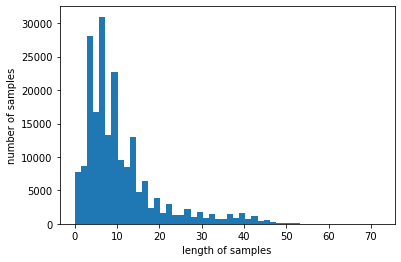

In [37]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### Word2Vec 로 임베딩 작업

In [38]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [39]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16496, 100)

In [40]:
print(model.wv.most_similar("최민식"))

[('한석규', 0.8649274110794067), ('박중훈', 0.8449939489364624), ('양동근', 0.8370124101638794), ('송강호', 0.8335801959037781), ('안성기', 0.8308054804801941), ('서영희', 0.82659912109375), ('최민수', 0.8215177655220032), ('크리스찬', 0.8165842890739441), ('김수현', 0.8155043125152588), ('윤제문', 0.8132871389389038)]


In [41]:
print(model.wv.most_similar("히어로"))

[('슬래셔', 0.873779833316803), ('무협', 0.8485158681869507), ('느와르', 0.8464115858078003), ('호러', 0.8270326256752014), ('물의', 0.8188697695732117), ('블랙', 0.8039942979812622), ('물', 0.8033729791641235), ('판타지', 0.8019105195999146), ('무비', 0.7992755174636841), ('교과서', 0.788824200630188)]


In [48]:
print(model.wv.most_similar("가족"))

[('연인', 0.6967545747756958), ('부모', 0.6643023490905762), ('우리', 0.6521469354629517), ('아이', 0.6331598162651062), ('가정', 0.6215140223503113), ('어른', 0.6214463710784912), ('행복', 0.6156924962997437), ('서로', 0.6155820488929749), ('연애', 0.6117792725563049), ('어머니', 0.6106224656105042)]


### Word2Vec 정리
- Word2Vec은 단어를 밀집벡터로 만드는데 도움을 준다.
- 그리고 , 추천시스템과 실시간 검색어 등 다양하게 사용될 수 있다고 생각된다
- 현재 추천시스템에서 Item2Vec를 많이 사용한다고 한다.

# Item2Vec
- 추천시스템에서는 주로 Word2Vec을 상품을 vector화 시킬 때 사용한다 .
- 이렇게 Vector화 시킨 결과는 유사한 상품 추천 , 마이크로 카테고라이징 , 의미 벡터로써 활용한다.
- 활용 사례
    - __live2vec__ : 아프리카 TV에서 Live 방송을 벡터화
    - __song2vec__ : Sporify(음원 스트리밍)에서 플레이리스트로 노래 벡터화
    - __mtea-pro2vec__ : Criteo(개인화 광고)에서 상품을 벡터화